# Dense 3D Face Correspondence

In [1]:
# import os
# os.environ["MKL_NUM_THREADS"] = "1" 
# os.environ["NUMEXPR_NUM_THREADS"] = "1" 
# os.environ["OMP_NUM_THREADS"] = "1" 

In [5]:
import pdb
import numpy as np
import re
import threading
import cv2
import ipyvolume as ipv
import scipy
from math import cos, sin
from scipy import meshgrid, interpolate
import pdb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull, Delaunay
import numpy as np
from scipy.interpolate import griddata

# THRESHOLDS
rho = 0.5
eigen_ratio_threshold = 5000

In [31]:
'''def read_wrl(file_path,var_name):
    holder = []
    with open(file_path, "r") as vrml:
        for line in vrml:
            a = line.strip().strip(",").split()
            if len(a) == 3:
                try:
                    holder.append(list(map(float, a)))
                except:
                    pass
    x,y,z = zip(*holder)
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    face_points[var_name] = np.array(holder)'''

In [32]:
'''file_paths = {
    "path1": "F0001/F0001_AN01WH_F3D.wrl",
    "path2": "F0001/F0001_AN02WH_F3D.wrl",
    "path3": "F0001/F0001_AN03WH_F3D.wrl",
    "path4": "F0001/F0001_AN04WH_F3D.wrl",
    "path5": "F0001/F0001_DI01WH_F3D.wrl",
    "path6": "F0001/F0001_DI02WH_F3D.wrl",
    "path7": "F0001/F0001_DI03WH_F3D.wrl",
    "path8": "F0001/F0001_DI04WH_F3D.wrl",
    
}
face_points = {} # key = face+index, value = extracted face data
for i in range(1, len(file_paths)+1):
    thread = threading.Thread(target=read_wrl,args=(file_paths["path" + str(i)],"face" + str(i)))
    thread.start()
    #face_points["face" + str(i)] = read_wrl(file_paths["path" + str(i)])

while len(face_points) != len(file_paths):
    time.sleep(0.1)'''

{'face1': array([[  27.4703,  -60.5966,  -23.9859],
        [  27.6342,  -58.5174,  -24.2949],
        [  25.9556,  -59.2863,  -23.2552],
        ...,
        [ -57.5708,  -39.7324,  -99.7084],
        [ -21.8135, -111.782 ,  -69.8048],
        [ -56.8643,  -42.279 ,  -98.5402]]),
 'face4': array([[ 43.3909, -66.4114,  31.1063],
        [ 43.5612, -64.4194,  30.3593],
        [ 41.7755, -65.0309,  31.3583],
        ...,
        [-56.5893, -44.8446, -24.7909],
        [-56.6231, -44.33  , -24.795 ],
        [-56.5394, -45.5457, -24.7848]]),
 'face5': array([[  55.2013,  -39.1401,   53.0094],
        [  55.4291,  -37.2959,   54.43  ],
        [  53.4106,  -38.2957,   53.9848],
        ...,
        [  21.7241, -137.298 ,   33.5786],
        [  29.2773, -137.096 ,   33.5565],
        [  25.9154, -137.702 ,   33.9256]]),
 'face3': array([[ 14.6083 ,  -6.74486,  38.8328 ],
        [ 14.6703 ,  -4.50074,  38.2945 ],
        [ 12.6999 ,  -5.58541,  38.1367 ],
        ...,
        [ 86.3475 ,  

In [19]:
'''
def normalize_face(points):
    maxind = np.argmax(points[:,2])
    nosex = points[maxind,0]
    nosey = points[maxind,1]
    nosez = points[maxind,2]
    points = points - np.array([nosex, nosey, nosez])
#     points = points / np.max(points)
    return points

def points2grid(points):
    x1, y1, z1 = map(np.array, zip(*points))
    grid_x, grid_y = np.mgrid[np.amin(x1):np.amax(x1):0.5, np.amin(y1):np.amax(y1):0.5]
    grid_z = griddata((x1, y1), z1, (grid_x, grid_y), method='linear')
    return [grid_x, grid_y, grid_z]
'''

"\ndef normalize_face(points):\n    maxind = np.argmax(points[:,2])\n    nosex = points[maxind,0]\n    nosey = points[maxind,1]\n    nosez = points[maxind,2]\n    points = points - np.array([nosex, nosey, nosez])\n#     points = points / np.max(points)\n    return points\n\ndef points2grid(points):\n    x1, y1, z1 = map(np.array, zip(*points))\n    grid_x, grid_y = np.mgrid[np.amin(x1):np.amax(x1):0.5, np.amin(y1):np.amax(y1):0.5]\n    grid_z = griddata((x1, y1), z1, (grid_x, grid_y), method='linear')\n    return [grid_x, grid_y, grid_z]\n"

In [5]:
# normalizing the faces and interpolating them across a grid
#grid_data = {}
#for i in range(1, len(file_paths)+1):
    # normalization
 #   face_points["face" + str(i)] = normalize_face(face_points["face" + str(i)])
    # grid interpolation of the face data
  #  grid_data["face" + str(i)] = points2grid(face_points["face" + str(i)])

### Read Each face data, normalize it and then interpolate it parallely

In [6]:
#Read each face data, normalize it and get the interpolation it in a parallel fashion
def get_data(file_path,var_name):
    #global points and grid data structure which will be modified by all threads
    global face_points
    global grid_data
    holder = []
    #reading face data from path
    with open(file_path, "r") as vrml:
        for line in vrml:
            a = line.strip().strip(",").split()
            if len(a) == 3:
                try:
                    holder.append(list(map(float, a)))
                except:
                    pass
    x,y,z = zip(*holder)
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    holder = np.array(holder)
    #normalizing face
    maxind = np.argmax(holder[:,2])
    nosex = holder[maxind,0]
    nosey = holder[maxind,1]
    nosez = holder[maxind,2]
    holder = holder - np.array([nosex, nosey, nosez])
    face_points[var_name] = holder
    x1, y1, z1 = map(np.array, zip(*holder))
    grid_x, grid_y = np.mgrid[np.amin(x1):np.amax(x1):0.5, np.amin(y1):np.amax(y1):0.5]
    grid_z = griddata((x1, y1), z1, (grid_x, grid_y), method='linear')
    grid_data[var_name] = [grid_x, grid_y, grid_z]  
  


In [7]:
face_points = {}
grid_data = {}
file_paths = {
    "path1": "F0001/F0001_AN01WH_F3D.wrl",
    "path2": "F0001/F0001_AN02WH_F3D.wrl",
    "path3": "F0001/F0001_AN03WH_F3D.wrl",
    "path4": "F0001/F0001_AN04WH_F3D.wrl",
    "path5": "F0001/F0001_DI01WH_F3D.wrl",
    "path6": "F0001/F0001_DI02WH_F3D.wrl",
    "path7": "F0001/F0001_DI03WH_F3D.wrl",
    "path8": "F0001/F0001_DI04WH_F3D.wrl",
    
}

for i in range(1,len(file_paths)+1):
    thread = threading.Thread(target=get_data,args=(file_paths["path"+str(i)],"face"+str(i)))
    thread.start()
    


In [8]:
face_points

{'face5': array([[ 28.3164,  19.3635, -30.6283],
        [ 28.5442,  21.2077, -29.2077],
        [ 26.5257,  20.2079, -29.6529],
        ...,
        [ -5.1608, -78.7944, -50.0591],
        [  2.3924, -78.5924, -50.0812],
        [ -0.9695, -79.1984, -49.7121]]),
 'face2': array([[-10.3441,  52.0685, -16.0251],
        [-10.2018,  54.3407, -15.8771],
        [-12.2854,  53.2507, -16.1921],
        ...,
        [ 66.4235, -12.7342, -96.022 ],
        [-65.1096,  -7.9123, -97.184 ],
        [-65.2804,  -7.3035, -97.568 ]]),
 'face3': array([[ -0.8147 ,  28.54654, -12.3373 ],
        [ -0.7527 ,  30.79066, -12.8756 ],
        [ -2.7231 ,  29.70599, -13.0334 ],
        ...,
        [ 70.9245 ,  29.50283, -70.0512 ],
        [ 70.8847 ,  30.85937, -70.1751 ],
        [ 70.9038 ,  32.56353, -70.3285 ]]),
 'face4': array([[ 35.22987,   4.0784 , -24.4649 ],
        [ 35.40017,   6.0704 , -25.2119 ],
        [ 33.61447,   5.4589 , -24.2129 ],
        ...,
        [-64.75033,  25.6452 , -80.3621

In [9]:
# hull plot
first_face_id = 3 # face id (number) to plot
second_face_id = 7
points = face_points["face" + str(first_face_id)]
points2 = face_points["face" + str(second_face_id)]
ipv.quickscatter(points[:, 0], points[:, 1], points[:, 2], size=1, marker="sphere")
ipv.scatter(points2[:, 0], points2[:, 1], points2[:, 2], size=1, marker="sphere", color="blue")
ipv.show()

## Plot the interpolated faces

In [10]:

face_id = 8
ipv.clear()
grid_x, grid_y, grid_z = grid_data["face" + str(face_id)]
ipv.plot_mesh(grid_x, grid_y, grid_z, wireframe=False)
ipv.show()

## Sparse Correspondence Initialization

## Seed points sampling using mean 2D convex hull 

In [8]:
def hull72(points, nosex, nosey, nosez):
    newhull = [[nosex, nosey, nosez]]
    for theta in range(0, 360, 5):
        fx = 200 * cos(theta * np.pi / 180)
        fy = 200 * sin(theta * np.pi / 180)
        nearest_point = min(zip(points[:, 0], points[:, 1], points[:, 2]), key=lambda p:(p[0] - fx)**2 + (p[1] - fy)**2)
        newhull.append(nearest_point)
    return newhull

def get_hull(points):
    maxind = np.argmax(points[:,2])
    # coordinates of nose, nosex = x coordinate of nose, similarly for nosey and nosez
    nosex = points[maxind,0]
    nosey = points[maxind,1]
    nosez = points[maxind,2]
    hull = np.array(hull72(points, nosex,nosey,nosez))
    return hull

hull = np.zeros([73, 3])
for i in range(1, len(file_paths)+1):
    hull += get_hull(face_points["face" + str(i)])
hull = hull / len(file_paths)

### Plot of extracted seed points

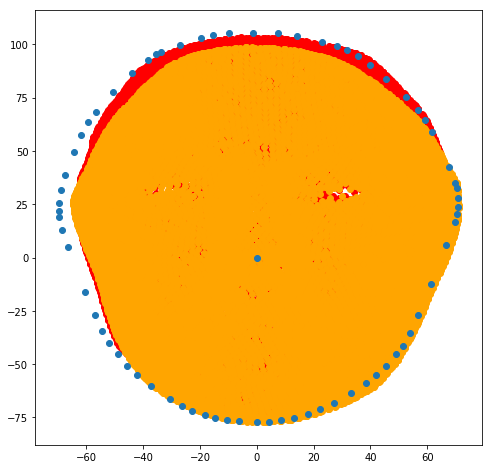

In [9]:
first_face_index = 7
second_face_index = 4
points1 = face_points["face" + str(first_face_index)]
points2 = face_points["face" + str(second_face_index)]
plt.figure(figsize=(8,8))
plt.scatter(points1[:,0], points1[:,1], color="red")
plt.scatter(points2[:,0], points2[:,1], color="orange")
plt.scatter(hull[:,0], hull[:,1])
maxind = np.argmax(points1[:,2])
nosex = points1[maxind,0]
nosey = points1[maxind,1]
nosez = points1[maxind,2]
plt.plot(nosex,nosey,"b")
plt.show()

## Delaunay Triangulation 

In [10]:
def do_triangulation(hull):
    points2D = np.vstack([hull[:,0],hull[:,1]]).T
    tri_hull = Delaunay(points2D) 
    return tri_hull

In [11]:
tri_hull = do_triangulation(hull)

In [12]:
ipv.figure()
mesh = ipv.plot_trisurf(hull[:,0], hull[:,1], hull[:,2], triangles=tri_hull.simplices, color='blue')
ipv.scatter(hull[:,0], hull[:,1], hull[:,2], marker='sphere', color='red')
ipv.show()

## Geodesic Patch Extraction

In [14]:
def get_patch(points, hull, x1, y1, z1):
    patch_width = 5 * rho
    def distance(x,y,z,x1,y1,z1,x2,y2,z2):
        a = (y2-y1)/(x2-x1)
        b = -1
        c = y2-x2*(y2-y1)/(x2-x1)
        return abs(a*x+b*y+c)/(a**2+b**2)**0.5

    patch = []
    nosex, nosey, nosez = hull[0]
    for x2,y2,z2 in points:
        if (y1-nosey)/(y2-nosey+0.0001)>0 and (x1-nosex)/(x2-nosex+0.0001)>0 \
        and distance(x2,y2,z2,x1,y1,z1,nosex,nosey,nosez)<patch_width:
            patch.append([x2,y2,z2])
    patch = np.array(patch)
    return patch

In [15]:
def get_patches(hull):
    patches = {} # key = edges, values = a list of extracted patches from all faces along that edge 
    for edge_index in range(1, len(hull)): # skipping the nose point
        x1, y1, z1 = hull[edge_index, :]
        patch_list = []
        for face_index in range(1, len(file_paths)+1): # we have to extract patches along `edge_index` across all faces
            patch = get_patch(face_points["face" + str(face_index)], hull, x1, y1, z1)
            patch_list.append(patch)
        patches["edge" + str(edge_index)] = patch_list
    return patches

patches = get_patches(hull)

In [16]:
# randomly selecting a edge, and plotting all patches along that edge across all the faces
ipv.clear()
edge_index = np.random.choice(range(len(patches)))
edge = patches["edge" + str(edge_index)]
for i in range(len(edge)):
    patch = edge[i]
    ipv.scatter(patch[:,0], patch[:,1], patch[:,2], size=1, marker="sphere", color=["red", "blue", "yellow", "green"][i%4])
ipv.show()

## Keypoint Extraction

In [17]:
# takes in a point and the patch it belongs to and decides whether it is a keypoint (ratio of largest two eigenvalues on the covariance matrix of its local surface) or not
def is_keypoint(point, points):
    threshold = 7 * rho
    nhood = points[(np.sum(np.square(points-point),axis=1)) < threshold**2]
    try:
        nhood = (nhood - np.min(nhood, axis=0)) / (np.max(nhood, axis=0) - np.min(nhood, axis=0))
        covmat = np.cov(nhood)
        eigvals = np.sort(np.abs(np.linalg.eigvalsh(covmat)))
        ratio = eigvals[-1]/(eigvals[-2]+0.0001)
        return ratio>30 #eigen_ratio_threshold #/ 5
    except Exception as e:
        return False


In [18]:
def get_keypoints(patches):
    keypoints = {} # key = edge, value = a list of keypoints extracted from the patches along that edge across all faces
    for edge_index in range(1, len(patches)+1):
        edge_patches = patches["edge" + str(edge_index)]
        edge_keypoints = []
        for patch in edge_patches:
            #print(patch)
            patch_keypoints = patch[np.apply_along_axis(is_keypoint, 1, patch, patch)] # keypoints in `patch`
            edge_keypoints.append(patch_keypoints)
        keypoints["edge" + str(edge_index)] = edge_keypoints 
    return keypoints

keypoints = get_keypoints(patches)

/home/ags/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [19]:
# plot keypoints of a face, given the face index
face_index = 1
face_keypoints = []
for edge_index in range(1, len(keypoints)+1):
    face_keypoints.extend(keypoints["edge" + str(edge_index)][face_index-1])
face_keypoints = np.array(face_keypoints)
print(face_keypoints.shape)
#print(face_keypoints)
points = face_points["face" + str(face_index)]
ipv.clear()
ipv.scatter(points[:,0], points[:,1], points[:,2], size=1, marker="sphere", color="blue")
ipv.scatter(face_keypoints[:, 0], face_keypoints[:,1], face_keypoints[:,2], size=1, marker="sphere", color="red")
ipv.show()

(1918, 3)


## Feature Extraction

In [20]:

def get_normal(x, y, grid_x, grid_y, grid_z):
    '''
      3
    1   2
      4
    x, y are coordinates of the point for which the normal has to be calculated
    '''
    i = (x - grid_x[0, 0]) / (grid_x[1, 0] - grid_x[0, 0])
    j = (y - grid_y[0, 0]) / (grid_y[0, 1] - grid_y[0, 0])
    i,j = int(round(i)), int(round(j))
    if (not 0 <= i < grid_x.shape[0]-1) or (not 0 <= j < grid_y.shape[1]-1):
        print("out of bounds error")
        #pdb.set_trace()
        return "None"
    point1 = (grid_x[i-1, j], grid_y[i-1, j], grid_z[i-1, j])
    point2 = (grid_x[i+1, j], grid_y[i+1, j], grid_z[i+1, j])
    point3 = (grid_x[i, j-1], grid_y[i, j-1], grid_z[i, j-1])
    point4 = (grid_x[i, j+1], grid_y[i, j+1], grid_z[i, j+1])
    a1, a2, a3 = [point2[x] - point1[x] for x in range(3)]
    b1, b2, b3 = [point3[x] - point4[x] for x in range(3)]
    normal = np.array([a3*b2, a1*b3, -a1*b2])
    return normal/np.linalg.norm(normal)



In [21]:
# test the get_normal function and plot 
'''If this snippet throws an error, rerun it'''
face_id = 8
grid_x, grid_y, grid_z = grid_data["face" + str(face_id)]
i = np.random.choice(len(grid_x))
j = np.random.choice(len(grid_y))
x, y = grid_x[i, 0], grid_y[0, j]
print(i, j, x, y)
uvn = get_normal(x, y, grid_x, grid_y, grid_z)

ipv.clear()
ipv.plot_mesh(grid_x, grid_y, grid_z, wireframe=False)
ipv.quiver(np.array([x, ]), np.array([y,]), np.array([grid_z[i, j]]), np.array([uvn[0]]), np.array([uvn[1]]), np.array([uvn[2]]), color="blue", size=10)
ipv.show()

28 197 -53.19630000000001 22.619100000000003


In [22]:
# moments = cv2.moments(patch2[:, :2])
# central_moments = [moments[key] for key in moments.keys() if key[:2] == "mu"]
# central_moments = np.array(central_moments)
# central_moments

In [22]:
def get_keypoint_features(keypoints, face_index):
    feature_list = [] # a list to store extracted features of each keypoint
    final_keypoints = [] # remove unwanted keypoints, like the ones on edges etc
    for point in keypoints:
        point_features = []
        x, y, z = point
        points = face_points["face" + str(face_index)]
        grid_x, grid_y, grid_z = grid_data["face" + str(face_index)]
        threshold = 5 * rho
        nhood = points[(np.sum(np.square(points-point), axis=1)) < threshold**2]
        xy_hu_moments = cv2.HuMoments(cv2.moments(nhood[:, :2])).flatten()
        yz_hu_moments = cv2.HuMoments(cv2.moments(nhood[:, 1:])).flatten()
        xz_hu_moments = cv2.HuMoments(cv2.moments(nhood[:, ::2])).flatten()
        hu_moments = np.concatenate([xy_hu_moments, yz_hu_moments, xz_hu_moments])
        #print(hu_moments)
        #i = (x - grid_x[0, 0]) / (grid_x[1, 0] - grid_x[0, 0])
        #j = (y - grid_y[0, 0]) / (grid_y[0, 1] - grid_y[0, 0])
        #i, j = int(round(i)), int(round(j))
        #start_i, start_j = i - int(5 * rho / (grid_x[1, 0] - grid_x[0, 0])), j - int(5 * rho / (grid_y[0, 1] - grid_y[0, 0]))
        #end_i, end_j = i + int(5 * rho / (grid_x[1, 0] - grid_x[0, 0])), j + int(5 * rho / (grid_y[0, 1] - grid_y[0, 0]))
        #nhood = points[start_i: end_i, start_j: end_j] 
        #nhood_x = grid_x[start_i:end_i, start_j:end_j]
        #nhood_y = grid_y[start_i:end_i, start_j:end_j]
        #nhood_z = grid_z[start_i:end_i, start_j:end_j]
        normal = get_normal(x, y, grid_x, grid_y, grid_z)
        if normal == "None": # array comparision raises ambiguity error, so None passed as string
            continue
        final_keypoints.append(point)
        point_features.extend(np.array([x, y, z])) # spatial location
        point_features.extend(normal)
        point_features.extend(hu_moments)
        point_features = np.array(point_features)
        
        feature_list.append(point_features)
    final_keypoints = np.array(final_keypoints)
    return final_keypoints, feature_list

In [23]:
def get_features(keypoints):
    features = {} # key = edge + edge_index, value = list of features for each keypoint across all the faces
    for edge_index in range(1, len(keypoints)+1):
        edgewise_keypoint_features = [] # store features of keypoints for a given edge_index across all faces
        for face_index in range(1, len(file_paths)+1):
            edge_keypoints = keypoints["edge" + str(edge_index)][face_index-1]
            final_keypoints, keypoint_features = get_keypoint_features(edge_keypoints, face_index)
            keypoints["edge" + str(edge_index)][face_index-1] = final_keypoints # update the keypoint, remove unwanted keypoints like those on the edge etc
            edgewise_keypoint_features.append(keypoint_features)
        features["edge" + str(edge_index)] = edgewise_keypoint_features
    return features

features = get_features(keypoints)

/home/ags/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


out of bounds error
out of bounds error
out of bounds error


In [24]:
def get_keypoint_under_2rho(keypoints, point):
    """return the index of the keypoint in `keypoints` which is closest to `point` if that distance is less than 2 * rho, else return None"""
    try:
        distance = np.sqrt(np.sum(np.square(keypoints-point), axis=1))
        if (distance < 3*rho).any():
            min_dist_index = np.argmin(distance)
            return min_dist_index
    except Exception as e: # keypoints is [], gotta return None
        pass
    return None

def get_matching_keypoints(edge_keypoints, edge_features, edge_index):
    # check if a bunch of keypoints across the patches (across all faces) are withing 2*rho
    # first get all the keypoints in a list
    matching_keypoints_list = []
    for face_index1 in range(len(edge_keypoints)): # take a patch along the edge among the faces
        for point_index, point in enumerate(edge_keypoints[face_index1]): # take a keypoint in that patch, we have to find corresponding keypoints in each other patche along this edge
            matched_keypoint_indices = [] # to store indices of matched keypoints across the patches
            for face_index2 in range(len(edge_keypoints)): # find if matching keypoints exist across the patches along that edge across all faces
                if face_index2 == face_index1: 
                    matched_keypoint_indices.append(point_index)
                    continue
                matched_keypoint = get_keypoint_under_2rho(edge_keypoints[face_index2], point)
                if matched_keypoint:
                    #if edge_index == 36: pdb.set_trace()I#
                    matched_keypoint_indices.append(matched_keypoint)
                else: # no keypoint was matched in the above patch (face_index2), gotta start search on other keypoint from face_index1
                    break
                        
            if len(matched_keypoint_indices) == len(edge_keypoints): # there's a corresponding keypoint for each patch across all faces
                 matching_keypoints_list.append(matched_keypoint_indices)
    if len(matching_keypoints_list) == 0:
        return []
    # now we have those keypoints which are in vicinity of 2*rho, let's compute euclidean distance of their feature vectors
    Kq = 2
    final_matched_keypoints = []
    for matched_keypoints in matching_keypoints_list: # select first list of matching keypoints
        # get the indices, get their corresponding features, compute euclidean distance
        try:
            features = np.array([edge_features[face_index][idx] for face_index, idx in zip(range(len(edge_features)), matched_keypoints)])
            euc_dist_under_kq = lambda feature, features: np.sqrt(np.sum(np.square(features - feature), axis=1)) < Kq
            if np.apply_along_axis(euc_dist_under_kq, 1, features, features).all() == True:
                # we have got a set of matching keypoints, get their mean coordinates
                matched_coords = [edge_keypoints[face_index][idx] for face_index, idx in zip(range(len(edge_features)), matched_keypoints)]
                final_matched_keypoints.append(np.mean(matched_coords, axis=0))
        except:
            pdb.set_trace()
    return final_matched_keypoints



In [25]:
# those keypoints which are in vicinity of 2*rho are considered for matching
# matching is done using constrained nearest neighbour
# choose an edge, select a keypoint, find out keypoints on corresponding patches on other faces within a vicinity of 2*rho, 
# get euclidean distance in features among all possible pair wise combinations, if the distances come out to be less than Kp are added to the global set of correspondences
def keypoint_matching_process(keypoints, features):
    final_mean_keypoints = []
    for edge_index in range(1, len(keypoints)):
        edge_keypoints = keypoints["edge" + str(edge_index)]
        edge_features = features["edge" + str(edge_index)]
        matched_keypoints = get_matching_keypoints(edge_keypoints, edge_features, edge_index)
        if len(matched_keypoints) == 0:
            continue
        #print(matched_keypoints)
        final_mean_keypoints.extend(matched_keypoints)
    #final_mean_keypoints = list(set(final_mean_keypoints))

    final_mean_keypoints = np.array(final_mean_keypoints)
    final_mean_keypoints = np.unique(final_mean_keypoints, axis=0)
    return final_mean_keypoints

final_mean_keypoints = keypoint_matching_process(keypoints, features)
print("Iteration completed")
print(len(final_mean_keypoints), "new keypoints found")
print(final_mean_keypoints)

Iteration completed
2 new keypoints found
[[-9.07440588  0.8437375  -4.63839525]
 [-1.65064375 -6.3524375  -3.1287075 ]]


In [99]:
updated_hull = np.concatenate((hull, final_mean_keypoints), axis=0)

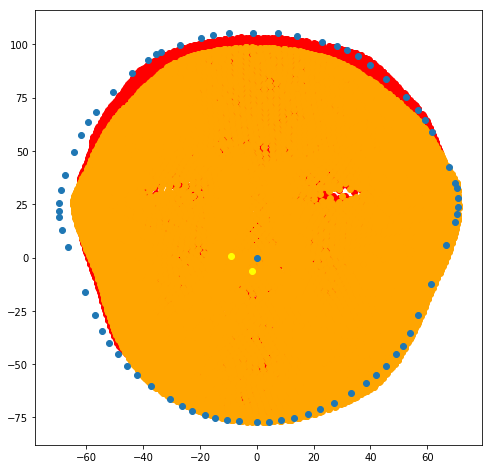

In [26]:
first_face_index = 7
second_face_index = 4
points1 = face_points["face" + str(first_face_index)]
points2 = face_points["face" + str(second_face_index)]
plt.figure(figsize=(8,8))
plt.scatter(points1[:,0], points1[:,1], color="red")
plt.scatter(points2[:,0], points2[:,1], color="orange")
#plt.scatter(updated_hull[:,0], updated_hull[:,1])

plt.scatter(hull[:,0], hull[:,1])
plt.scatter(final_mean_keypoints[:, 0], final_mean_keypoints[:, 1], color="yellow")
maxind = np.argmax(points1[:,2])
nosex = points1[maxind,0]
nosey = points1[maxind,1]
nosez = points1[maxind,2]
plt.plot(nosex,nosey,"b")
plt.show()

In [27]:
ipv.clear()
ipv.scatter(points[:,0], points[:,1], points[:,2], size=1, marker="sphere", color="blue")
ipv.scatter(final_mean_keypoints[:, 0], final_mean_keypoints[:,1], final_mean_keypoints[:,2], size=2, marker="sphere", color="red")
ipv.show()

In [28]:
xy_hu_moments = cv2.HuMoments(cv2.moments(patch2[:, :2])).flatten()
yz_hu_moments = cv2.HuMoments(cv2.moments(patch2[:, 1:])).flatten()
xz_hu_moments = cv2.HuMoments(cv2.moments(patch2[:, ::2])).flatten()
hu_moments = np.concatenate([xy_hu_moments, yz_hu_moments, xz_hu_moments])
hu_moments.shape


NameError: name 'patch2' is not defined

In [ ]:
def surface_curvature(X,Y,Z):

    (lr,lb)=X.shape


    #First Derivatives
    Xv,Xu=np.gradient(X)
    Yv,Yu=np.gradient(Y)
    Zv,Zu=np.gradient(Z)

    #Second Derivatives
    Xuv,Xuu=np.gradient(Xu)
    Yuv,Yuu=np.gradient(Yu)
    Zuv,Zuu=np.gradient(Zu)   

    Xvv,Xuv=np.gradient(Xv)
    Yvv,Yuv=np.gradient(Yv)
    Zvv,Zuv=np.gradient(Zv) 

    #2D to 1D conversion 
    #Reshape to 1D vectors
    Xu=np.reshape(Xu,lr*lb)
    Yu=np.reshape(Yu,lr*lb)
    Zu=np.reshape(Zu,lr*lb)
    Xv=np.reshape(Xv,lr*lb)
    Yv=np.reshape(Yv,lr*lb)
    Zv=np.reshape(Zv,lr*lb)
    Xuu=np.reshape(Xuu,lr*lb)
    Yuu=np.reshape(Yuu,lr*lb)
    Zuu=np.reshape(Zuu,lr*lb)
    Xuv=np.reshape(Xuv,lr*lb)
    Yuv=np.reshape(Yuv,lr*lb)
    Zuv=np.reshape(Zuv,lr*lb)
    Xvv=np.reshape(Xvv,lr*lb)
    Yvv=np.reshape(Yvv,lr*lb)
    Zvv=np.reshape(Zvv,lr*lb)

    Xu=np.c_[Xu, Yu, Zu]
    Xv=np.c_[Xv, Yv, Zv]
    Xuu=np.c_[Xuu, Yuu, Zuu]
    Xuv=np.c_[Xuv, Yuv, Zuv]
    Xvv=np.c_[Xvv, Yvv, Zvv]

    #% First fundamental Coeffecients of the surface (E,F,G)
    E=np.einsum('ij,ij->i', Xu, Xu) 
    F=np.einsum('ij,ij->i', Xu, Xv) 
    G=np.einsum('ij,ij->i', Xv, Xv) 

    m=np.cross(Xu,Xv,axisa=1, axisb=1) 
    p=np.sqrt(np.einsum('ij,ij->i', m, m)) 
    n=m/np.c_[p,p,p]
    # n is the normal
    #% Second fundamental Coeffecients of the surface (L,M,N), (e,f,g)
    L= np.einsum('ij,ij->i', Xuu, n) #e
    M= np.einsum('ij,ij->i', Xuv, n) #f
    N= np.einsum('ij,ij->i', Xvv, n) #g

    # Alternative formula for gaussian curvature in wiki 
    # K = det(second fundamental) / det(first fundamental)
    #% Gaussian Curvature
    K=(L*N-M**2)/(E*G-L**2)
    K=np.reshape(K,lr*lb)
    #wiki trace of (second fundamental)(first fundamental inverse)
    #% Mean Curvature
    H = (E*N + G*L - 2*F*M)/((E*G - F**2))
    H = np.reshape(H,lr*lb)

    #% Principle Curvatures
    Pmax = H + np.sqrt(H**2 - K)
    Pmin = H - np.sqrt(H**2 - K)
    #[Pmax, Pmin]
    return [Pmax, Pmin, G, H]


def fun(x,y):
    return x**2+y**2

In [ ]:
x1, y1, z1 = patch1[:, 0], patch1[:, 1], patch1[:, 2]

In [ ]:
[pgrid_x,pgrid_y] = scipy.meshgrid(x1, y1)

In [ ]:
plt.scatter(pgrid_x, pgrid_y);
plt.scatter(x1, y1)

In [ ]:
pgrid_z = scipy.interpolate.griddata((patch1[:, 0], patch1[:, 1]), patch1[:, 2], (pgrid_x, pgrid_y), method='cubic')

In [ ]:
ipv.figure()
ipv.plot_surface(pgrid_x, pgrid_z, pgrid_y)
ipv.show()

In [ ]:
k1, k2, G, H = surface_curvature(pgrid_x,pgrid_y,pgrid_z)

In [ ]:
k1, k2, G, H

In [ ]:
for i in range(len(patch1)):
    print(k1[i*i])

In [ ]:
# Shape index

Sa = 1/2 - 1/np.pi * np.arctan((k1+k2)/(k1-k2))
Sb = 2/np.pi * np.arctan((k1+k2)/(k1-k2))

print(Sa)
print(Sb)

In [ ]:
curvedness = np.sqrt((k1**2 + k2**2)/2)
log_curvedness = 2/np.pi * np.log10(curvedness)
willmore_energy = H**2 - G
shape_curvedness = Sb * log_curvedness
log_difference_map = np.log(G - H + 1) 
